In [1]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import gc
Deletedata=["concut_1_delete","concut_2_delete","concut_3_delete","concut_4_delete","concut_5_delete"]
from densenet_num_classes_201 import densenet264
device=torch.device("cuda"if torch.cuda.is_available() else "cpu")
print(device)
net_num=264
net_txt="dense"+f"{net_num}"
scaler = torch.cuda.amp.GradScaler(init_scale=4096)


cuda


2514300


100%|██████████| 120/120 [19:47:55<00:00, 593.96s/it]  


loss:0.0002974738890770823


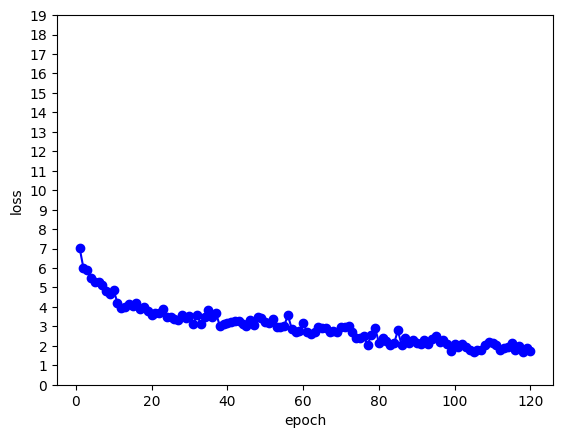

2514300


100%|██████████| 120/120 [26:41:22<00:00, 800.69s/it]   

loss:0.0002740113122854382


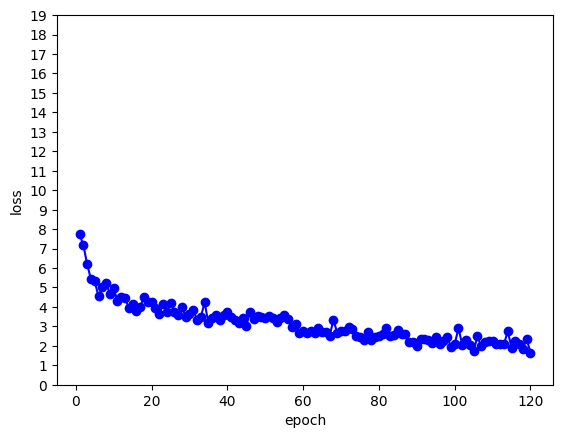

2514300


100%|██████████| 120/120 [34:08:40<00:00, 1024.34s/it]  

loss:0.0004984853439964354


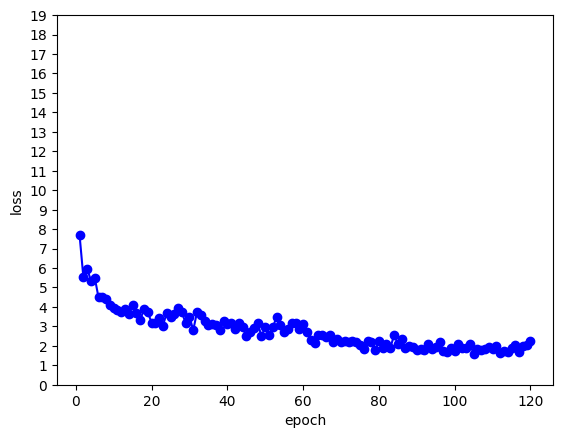

2531700


100%|██████████| 120/120 [19:59:06<00:00, 599.55s/it]  


loss:0.00041704432806000113


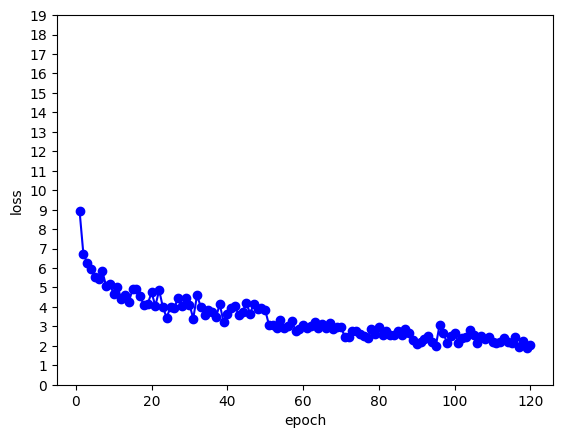

2531700


100%|██████████| 120/120 [19:57:50<00:00, 598.92s/it]  

loss:0.00023218823480419815


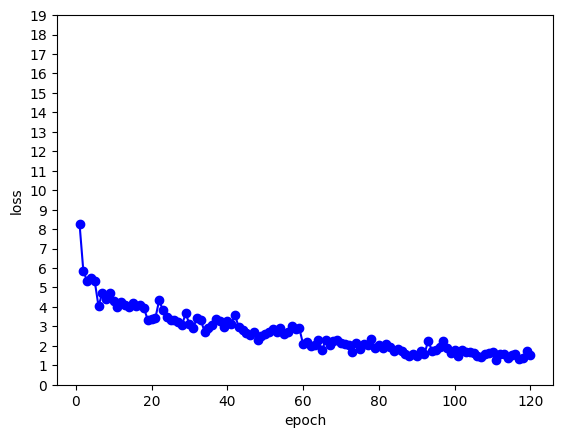

In [2]:
for Num,dataname in enumerate(Deletedata):
    max_epoch=120
    ganma_size=0.2
    minibatch=811
    batch_size=25141
    lr_size=1/(10*(batch_size/minibatch)) 
    from tqdm import tqdm
    import time
    from matplotlib import pyplot as plt
    net = densenet264().to(device)
    optimizer=torch.optim.Adam(net.parameters(),lr=lr_size)
    from torch.optim.lr_scheduler import StepLR
    #scheduler = StepLR(optimizer, step_size=step, gamma=ganma_size)
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=range(10,max_epoch,20), gamma=ganma_size)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=ganma_size, patience=10)

    dumpfile=f"C:\\Users\\KANDA\\Desktop\\モデル作業データ\\5分割trainデータ\\{dataname}_detaset.dump"
    with open(dumpfile, 'rb') as f:
        Traindata = pickle.load(f)
    x = Traindata[:,1:4,:]
    #透過率

    #基盤屈折率
    x[:,1,:]/=np.max(x[:,1,:])

    #基盤消衰係数
    x[:,2,:]/=np.max(x[:,2,:])

    t = Traindata[:,4:7,:]
    #膜厚
    t[:,0,:] /= np.max(t[:,0,:])

    #薄膜屈折率
    t[:,1,:] /= np.max(t[:,1,:])

    #薄膜消衰係数
    t[:,2,:] /= np.max(t[:,2,:])

    #print(x.shape,t.shape)
    #ndarrayからtensorに変換
    x=torch.tensor(x,dtype=torch.float32)
    t=torch.tensor(t,dtype=torch.float32)  #目標値は整数か少数か判断　今回は少数

    #入力値と目標値まとめる DataLoader
    dataset = torch.utils.data.TensorDataset(x,t)

    print(len(dataset))

    #ミニバッチ学習　#目安dataの十分の一から百分の一
    train_loader=torch.utils.data.DataLoader(dataset,batch_size,shuffle=True,drop_last=True) #目的関数をシャッフルにより変えていき極小解を抜け出す、dataに対しバッチが割り切れないときあまりを除外
    x,t=next(iter(train_loader)) #一つ目のバッジをとりだした
    #誤差リスト
    loss_list=[]
    file_name=f"201_{Num}_{net_txt}_batch_{batch_size}_lr={lr_size}_gamma_{ganma_size}"
    file_txt=f"{file_name}.txt"
    file_png=f"{file_name}.png"
    Number=str(Num)
    
    torch.cuda.empty_cache()
    loss_fn=nn.MSELoss()
    
    for epoch in tqdm(range(max_epoch)):
        net.train()
        gc.collect()
        for batch in train_loader:
            x_all,t_all=batch
            index = np.arange(0,x_all.size(0)+1,minibatch)
            optimizer.zero_grad()
            with torch.autocast(device_type=str(device)):
                for i in range(len(index)-1):
                    x=x_all[index[i]:index[i+1]].to(device)
                    t=t_all[index[i]:index[i+1]].to(device)
                    #print(x.type())
                    #print(t.type())
                    y=net(x)

                    #print(y.shape)
                    #print(t.shape)
                    t=t.reshape(t.shape[0], -1)[:,99:]
                    #print(t.shape)
                
                    loss=loss_fn(y,t) 
                    #print(loss.type())
                    net.to(device)
                scaler.scale(loss).backward()
            #リスケール　いるんかしらんがなんとなくつけた！
            scaler.unscale_(optimizer)
            #optimizer.step()
            scaler.step(optimizer)
            scaler.update()
        scheduler.step(loss)
        #誤差の書き出し処理
        Write_Value=loss.cpu().detach().numpy()
        Write_Value.tolist()
        loss_list.append(Write_Value.item())
        #誤差推移をリアルタイム観察
        with open(fr"C:\Users\KANDA\Desktop\モデル作業データ\{file_txt}", mode='a') as f:  
                f.write(f'{loss}\n')
        #print(f'loss:{loss}')
        #モデル情報をエポックごとに保存→テストデータ（読み込まない１/５データ）との誤差を比較するため～
        torch.save(net, fr"C:\Users\KANDA\Desktop\モデル作業データ\モデルデータcuda201\{Number}\{epoch}_{file_name}.pth")
        torch.save(net.cpu(), fr"C:\Users\KANDA\Desktop\モデル作業データ\モデルデータcpu201\{Number}\{epoch}_{file_name}.pth")
        net.to(device)
    print(f'loss:{loss}')
    #一応モデルの誤差グラフ
    from Plot import loss_plot
    loss_plot(loss_list,max_epoch)